<a href="https://colab.research.google.com/github/DeboraOliver/fraud_detection_project/blob/main/Fraude_cartoes_de_credito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instruções gerais

Para que se possa utilizar os códigos contidos nesse colab, é necessário fazer upload do dataset e colocá-lo na mesma altura do código. Na seção "Pré-processamento dos dados" é onde fazemos a leitura do dataset, veja o código e os comentários para entender melhor. Dê preferência para utilizar esses códigos no Goole colab ao invés de rodar localmente.

Esse projeto busca detectar fraudes em cartões de crédito baseado nas seguintes características:
*   **distance_from_home**: Distância entre a casa e o local em que o cartão foi utilizado.
*   **distance_from_last_transaction**: Distância para o último local em que o cartão foi utilizado.
*   **ratio_to_median_purchase_price**: Razão da transação do preço de compra para o preço de compra mediano
*   **repeat_retailer**: É a transação que aconteceu do mesmo varejista.
*   **used_chip**: É a transação através de chip (cartão de crédito).
*   **used_pin_number**: A transação aconteceu usando o número PIN.
*   **online_order**: A transação é um pedido online.

A base de dados é rotulada:
*   **fraud**: A transação é fraudulenta.

Por se tratar de uma base rotulada utilizaremos algoritmos de machine learning de aprendizado supervisionado. 

Mais informações, basta seguir as células abaixo!

# Bibliotecas e pacotes 

Importando as bibliotecas e pacotes necessários

In [1]:
# Arrays e gráficos
import pandas as pd
import numpy as np
import seaborn as sns

# undersampling
from imblearn.under_sampling import TomekLinks
#oversampling 
from imblearn.over_sampling import SMOTE

# Preprocessamento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Modelos
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Métricas de avaliação dos modelos
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Pré-processamento dos dados

In [2]:
# Lendo o dataset a partir do arquivo .csv
dataset = pd.read_csv('card_transdata.csv')

# Removendo dados iguais a null
dataset = dataset.dropna()
dataset = dataset.reset_index(drop=True)

# Descrição do dataset
dataset.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,137461.000000,137461.000000,137461.000000,137461.000000,137461.000000,137461.000000,137461.000000,137461.000000
mean,26.696987,5.002380,1.820350,0.881632,0.350492,0.102582,0.651327,0.087014
std,64.691814,24.080064,2.863814,0.323045,0.477126,0.303413,0.476552,0.281856
min,0.021322,0.000419,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.845361,0.294055,0.475531,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.943521,0.999509,0.996851,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.733759,3.341060,2.091091,1.000000,1.000000,0.000000,1.000000,0.000000
max,4601.011222,2160.499922,266.689692,1.000000,1.000000,1.000000,1.000000,1.000000


# Apenas used_chip = 1: fraude em cartão de crédito

In [27]:
dataset = dataset[dataset['used_chip']==1]

#Imprimindo o dataset
dataset

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0
10,14.263530,0.158758,1.136102,1.0,1.0,0.0,1.0,0.0
11,13.592368,0.240540,1.370330,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
137451,2.705421,4.351436,9.516795,1.0,1.0,0.0,0.0,0.0
137452,114.282653,0.511376,0.786856,1.0,1.0,0.0,1.0,0.0
137456,120.772291,1.915345,9.969406,1.0,1.0,0.0,1.0,1.0
137458,3.925273,1.218568,3.370015,1.0,1.0,1.0,1.0,0.0


## Análise exploratória do dataset

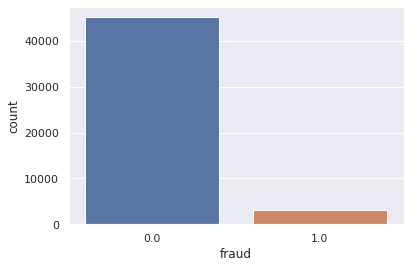

In [28]:
sns.set(style="darkgrid")
sns.countplot(x = dataset["fraud"]);

## Separação dos dados para treino e teste

Nesse caso, iremos utilizar 70% dos dados para treinamento e 30% para teste

In [29]:
# Extraindo do dataset as características (features) e o rótulo de cada linha (fraude = 1 e não-fraude = 0)
X_caracteristicas = dataset.iloc[:,0:7]
Y_classes = dataset.iloc[:,7]

# Split do dataset em treino (70%) e teste (30%) 
X_train, X_test, Y_train, Y_test = train_test_split(X_caracteristicas, Y_classes, test_size=0.3, random_state=0)

#pre-processamento
std_scaler = StandardScaler().fit(X_train)
X_train = std_scaler.transform(X_train)
X_test  = std_scaler.transform(X_test)


# Aplicação dos modelos de aprendizado supervisionado
De forma a avaliar diferentes modelos de aprendizado supervisionado, serão testados os seguintes algoritmos: random forest, naive bayes, SVM e regressão logística. Os valores de acurácia serão comparados no fim para definir qual a melhor abordagem para esse problema.

## Random Forest


Treinamento do modelo

In [30]:
random_forest_model = RandomForestClassifier(n_estimators = 250, random_state = 0)
#100 arvores = Acurácia :  0.9999515022187735, veja que 100 arvores é o default
#200 arvores = Acurácia :  0.9999515022187735
#250 arvores = Acurácia :  0.9999757511093867
#500 arvores = Acurácia :  0.9999757511093867 alcançou um platô
#1000 arvores = Acurácia :  0.9999757511093867 alcançou um platô
random_forest_model.fit(X_train, Y_train)

y_pred_random_forest = random_forest_model.predict(X_test)

Avaliação do modelo

In [31]:
def avaliacao_modelo(Y_test, y_pred_random_forest):

  # Acurácia
  accuracy = accuracy_score(Y_test, y_pred_random_forest)

  # Precisão
  precision = precision_score(Y_test, y_pred_random_forest, average='micro')

  # Recall
  recall  = recall_score(Y_test, y_pred_random_forest, average='micro')

  # f1-score
  f1 = f1_score(Y_test, y_pred_random_forest, average='micro')

  print("Acurácia : ", accuracy, "Precisão : ",precision, "Recall : ", recall, "f1-score : ",f1)

  return accuracy, precision, recall, f1

avaliacao_modelo(Y_test, y_pred_random_forest)

Acurácia :  0.9993773349937733 Precisão :  0.9993773349937733 Recall :  0.9993773349937733 f1-score :  0.9993773349937733


(0.9993773349937733,
 0.9993773349937733,
 0.9993773349937733,
 0.9993773349937733)

In [32]:
df_matriz_confusao_rf = pd.crosstab(Y_test, y_pred_random_forest).reset_index(drop=True)
df_matriz_confusao_rf['classificador'] = 'random_forest'
df_matriz_confusao_rf 

col_0,0.0,1.0,classificador
0,13530,0,random_forest
1,9,915,random_forest


## Nayve-Bayes 

Treinamento do modelo

In [33]:
classifier = GaussianNB() 

# Treinando o classificador Gaussian Naive Bayes:

classifier.fit(X_train, Y_train)

y_pred_naive_bayes =  classifier.predict(X_test)

Avaliação do modelo

In [34]:
#chamando a função que criamos anteriormente
avaliacao_modelo(Y_test, y_pred_naive_bayes)

Acurácia :  0.9782067247820673 Precisão :  0.9782067247820673 Recall :  0.9782067247820673 f1-score :  0.9782067247820673


(0.9782067247820673,
 0.9782067247820673,
 0.9782067247820673,
 0.9782067247820673)

In [35]:
df_matriz_confusao_nb = pd.crosstab(Y_test, y_pred_naive_bayes).reset_index(drop=True)
df_matriz_confusao_nb['classificador'] = 'naive_bayes'
df_matriz_confusao_nb 

col_0,0.0,1.0,classificador
0,13253,277,naive_bayes
1,38,886,naive_bayes


## SVM

Treinamento do modelo

In [36]:
svm = SVC(kernel='rbf', random_state=1, C = 2.0) 

svm.fit(X_train, Y_train)

y_pred_svm = svm.predict(X_test)

Avaliação do modelo

In [37]:
#chamando a  função criada anteriormente, apenas mudando 2º parametro
avaliacao_modelo(Y_test, y_pred_svm)

Acurácia :  0.9968174899681749 Precisão :  0.9968174899681749 Recall :  0.9968174899681749 f1-score :  0.9968174899681749


(0.9968174899681749,
 0.9968174899681749,
 0.9968174899681749,
 0.9968174899681749)

In [38]:
# matriz de confusão

df_matriz_confusao_svm = pd.crosstab(Y_test, y_pred_svm).reset_index(drop=True)
df_matriz_confusao_svm['classificador'] = 'svm'
df_matriz_confusao_svm 

col_0,0.0,1.0,classificador
0,13529,1,svm
1,45,879,svm


## Regressão Logística

Treinamento do modelo

In [39]:
regl = LogisticRegression(max_iter=1000, random_state=42)

regl.fit(X_train, Y_train)

y_pred_regressao = regl.predict(X_test)

Avaliação do modelo

In [40]:
#chamando a função criada anteriormente
avaliacao_modelo(Y_test, y_pred_regressao)

Acurácia :  0.9758544347585444 Precisão :  0.9758544347585444 Recall :  0.9758544347585444 f1-score :  0.9758544347585444


(0.9758544347585444,
 0.9758544347585444,
 0.9758544347585444,
 0.9758544347585444)

In [41]:
#matriz de confusão
df_matriz_confusao_rl = pd.crosstab(Y_test, y_pred_regressao).reset_index(drop=True)
df_matriz_confusao_rl['classificador'] = 'regressão logística'
df_matriz_confusao_rl

col_0,0.0,1.0,classificador
0,13492,38,regressão logística
1,311,613,regressão logística


# Avaliação dos modelos

### Resumo dos resultados

In [42]:
# resultados obtivos com o random forest
accuracy_rf, precision_rf, recall_rf, f1_rf = avaliacao_modelo(Y_test, y_pred_random_forest)
# resultados obtivos com o naive-bayes
accuracy_nb, precision_nb, recall_nb, f1_nb = avaliacao_modelo(Y_test, y_pred_naive_bayes)
# resultados obtivos com o svm
accuracy_svm, precision_svm, recall_svm, f1_svm = avaliacao_modelo(Y_test, y_pred_svm)
# resultados obtivos com a regressão Logística
accuracy_regl, precision_regl, recall_regl, f1_regl = avaliacao_modelo(Y_test, y_pred_regressao)

metrics = {
  "Random Forest": [accuracy_rf, precision_rf, recall_rf, f1_rf],
  "Naive-Bayes": [accuracy_nb, precision_nb, recall_nb, f1_nb],
  "SVM": [accuracy_svm, precision_svm, recall_svm, f1_svm],
  "Regressão":[accuracy_regl, precision_regl, recall_regl, f1_regl]
}

df = pd.DataFrame(metrics, index = ["Acurácia", "Precisão",  "Recall", "f1-score"])

df

Acurácia :  0.9993773349937733 Precisão :  0.9993773349937733 Recall :  0.9993773349937733 f1-score :  0.9993773349937733
Acurácia :  0.9782067247820673 Precisão :  0.9782067247820673 Recall :  0.9782067247820673 f1-score :  0.9782067247820673
Acurácia :  0.9968174899681749 Precisão :  0.9968174899681749 Recall :  0.9968174899681749 f1-score :  0.9968174899681749
Acurácia :  0.9758544347585444 Precisão :  0.9758544347585444 Recall :  0.9758544347585444 f1-score :  0.9758544347585444


,Random Forest,Naive-Bayes,SVM,Regressão
Acurácia,0.999377,0.978207,0.996817,0.975854
Precisão,0.999377,0.978207,0.996817,0.975854
Recall,0.999377,0.978207,0.996817,0.975854
f1-score,0.999377,0.978207,0.996817,0.975854


# Avaliação dos resultados

Como vimos acima o melhor resultado foi obtido usando o modelo Random Forest.

Agora vamos explorar um pouco mais este modelo. Para isso vamos trabalhar o problema de desbalanceamento do dataset comparando os resultados quando aplicamos a subamostragem, sobreamostragem e por fim, quando aplicamos ambos, subamostragem e sobreamostragem.

## Balanceamento do dataset  

Usando Tomek Link: o algoritmo busca por registros com alta similaridade, através do cálculo de distância e apaga os registros da classe majoritária.

Usando SMOTE : criamos novos registros sintéticos a fim de que a classe minoritária se equipare a classe majoritária.  

In [43]:
def subamostragem(dataset):

  X_caracteristicas_original = dataset.iloc[:,0:7]
  Y_classes_original = dataset.iloc[:,7]

  tl = TomekLinks(sampling_strategy='majority') 
  #usando o "majority" apenas os registros da classe majoritária será apagado
  X_caracteristicas, Y_classes = tl.fit_resample(X_caracteristicas_original, Y_classes_original) 

  # sns.countplot(x = Y_classes);

  return X_caracteristicas, Y_classes

def sobreamostragem(dataset):
  
  X_caracteristicas = dataset.iloc[:,0:7]
  Y_classes = dataset.iloc[:,7]

  smote = SMOTE(sampling_strategy='minority')
  X_over, Y_over = smote.fit_resample(X_caracteristicas, Y_classes) 
  # np.unique(Y_classes, return_counts=True)

  return X_over, Y_over

def sub_e_sobreamostragem(dataset):

  X_under, Y_under = subamostragem(dataset)

  smote = SMOTE(sampling_strategy='minority')
  X_under_over, Y_under_over = smote.fit_resample(X_under, Y_under) 
  # np.unique(Y_classes, return_counts=True)

  # sns.countplot(x = Y_under_over);

  return X_under_over, Y_under_over


## Random Forest 

In [44]:
def random_forest(dataset, metodo):
  
  if metodo == "sub":
    X_caracteristicas, Y_classes = subamostragem(dataset)
  elif metodo =="sobre":
    X_caracteristicas, Y_classes = sobreamostragem(dataset)
  else:
    X_caracteristicas, Y_classes = sub_e_sobreamostragem(dataset)


  # Split do dataset em treino (70%) e teste (30%) 
  X_train, X_test, Y_train, Y_test = train_test_split(X_caracteristicas, Y_classes, test_size=0.3, random_state=0)

  #pre-processamento
  std_scaler = StandardScaler().fit(X_train)
  X_train = std_scaler.transform(X_train)
  X_test  = std_scaler.transform(X_test)

#mantendo a mesma quantidade de  arvores
  random_forest_model = RandomForestClassifier(n_estimators = 250, random_state = 0)

  random_forest_model.fit(X_train, Y_train)

  y_pred_random_forest = random_forest_model.predict(X_test)

  print(metodo)
  
  accuracy, precision, recall, f1 = avaliacao_modelo(Y_test, y_pred_random_forest)

  df_matriz_confusao = pd.crosstab(Y_test, y_pred_random_forest).reset_index(drop=True)
  df_matriz_confusao['metodo'] = metodo

  return accuracy, precision, recall, f1, df_matriz_confusao

metodos = ['subamostragem','sobreamostragem','sub_e_sobreamostragem']
df_matrizes_confusao_rf = []
acuracias =[]

for metodo in metodos:
  accuracy_rf, precision_rf, recall_rf, f1_rf, matriz_confusao = random_forest(dataset, metodo)
  df_matrizes_confusao_rf.append(matriz_confusao)
  acuracias.append(accuracy_rf)  

#como colocar as metricas em um dataframe?

subamostragem
Acurácia :  0.9997033301194096 Precisão :  0.9997033301194096 Recall :  0.9997033301194096 f1-score :  0.9997033301194096
sobreamostragem
Acurácia :  0.999814581324631 Precisão :  0.999814581324631 Recall :  0.999814581324631 f1-score :  0.999814581324631
sub_e_sobreamostragem
Acurácia :  0.9998887487947786 Precisão :  0.9998887487947786 Recall :  0.9998887487947786 f1-score :  0.9998887487947786


In [45]:
metricas = {
  "metodo": metodos,
  "acuracia": acuracias
}

df_metricas_finais = pd.DataFrame(metricas, columns = ["metodo", "acuracia"])

df_metricas_finais


,metodo,acuracia
0,subamostragem,0.999703
1,sobreamostragem,0.999815
2,sub_e_sobreamostragem,0.999889


In [46]:
# As matrizes de confusao resultantes

resultados_matrizes_confusao = pd.concat(df_matrizes_confusao_rf)
resultados_matrizes_confusao

col_0,0.0,1.0,metodo
0,13394,0,subamostragem
1,8,13564,subamostragem
0,13394,0,sobreamostragem
1,5,13567,sobreamostragem
0,13394,0,sub_e_sobreamostragem
1,3,13569,sub_e_sobreamostragem


# Resultado Final

Ao testar os diferentes modelos de machine learning, a melhor acurácia  foi obtida ao utilizar o Random Forest. Após esta escolha do melhor modelo, voltamos ao dataset e testamos três métodos de tratar dados faltantes: subamostragem, sobreamostragem e ambos ao mesmo tempo. Por fim, encontramos que o melhor resultado foi obtido usando a subamostragem para tratar dados faltantes e em seguida, o Random Forest.

# Tabelas que usaremos no powerbi

In [23]:
# a tabela que compara os resultados dos modelos
df.to_csv('comparativo_modelos.csv')
df

,Random Forest,Naive-Bayes,SVM,Regressão
Acurácia,0.999976,0.949756,0.996823,0.958534
Precisão,0.999976,0.949756,0.996823,0.958534
Recall,0.999976,0.949756,0.996823,0.958534
f1-score,0.999976,0.949756,0.996823,0.958534


In [24]:
# as matrizes de confusão concatenadas
df_matrizes_confusao = pd.concat([df_matriz_confusao_rf, df_matriz_confusao_svm, df_matriz_confusao_nb, df_matriz_confusao_rl])
df_matrizes_confusao.to_csv('matrizes_confusao.csv')
df_matrizes_confusao

col_0,0.0,1.0,classificador
0,37630,0,random_forest
1,1,3608,random_forest
0,37593,37,svm
1,94,3515,svm
0,37081,549,naive_bayes
1,1523,2086,naive_bayes
0,37390,240,regressão logística
1,1470,2139,regressão logística


In [25]:
# as matrizes de confusao após os 3 processos: subamostragem, sobreamostragem e sub + sobreamostragem
resultados_matrizes_confusao.to_csv('matrizes_confusao_random_forest_final.csv')
resultados_matrizes_confusao

col_0,0.0,1.0,metodo
0,37452,1,subamostragem
1,0,37396,subamostragem
0,37453,0,sobreamostragem
1,2,37394,sobreamostragem
0,37451,2,sub_e_sobreamostragem
1,3,37393,sub_e_sobreamostragem


In [26]:
# o resultado após a aplicação dos diferentes métodos de amostragem 

df_metricas_finais.to_csv('metricas_apos_amostragem.csv')